## 8.1 reinforcement_learning

progress 0.00%
progress 1.71%
progress 3.42%
progress 5.13%
progress 6.84%
progress 8.55%
progress 10.26%
progress 11.97%
progress 13.68%
progress 15.40%
progress 17.11%
progress 18.82%
progress 20.53%
progress 22.24%
progress 23.95%
progress 25.66%
progress 27.37%
progress 29.08%
progress 30.79%
progress 32.50%
progress 34.21%
progress 35.92%
progress 37.63%
progress 39.34%
progress 41.05%
progress 42.76%
progress 44.47%
progress 46.19%
progress 47.90%
progress 49.61%
progress 51.32%
progress 53.03%
progress 54.74%
progress 56.45%
progress 58.16%
progress 59.87%
progress 61.58%
progress 63.29%
progress 65.00%
progress 66.71%
progress 68.42%
progress 70.13%
progress 71.84%
progress 73.55%
progress 75.27%
progress 76.98%
progress 78.69%
progress 80.40%
progress 82.11%
progress 83.82%
progress 85.53%
progress 87.24%
progress 88.95%
progress 90.66%
progress 92.37%
progress 94.08%
progress 95.79%
progress 97.50%
progress 99.21%
progress 0.00%
progress 1.71%
progress 3.42%
progress 5.13%
pr

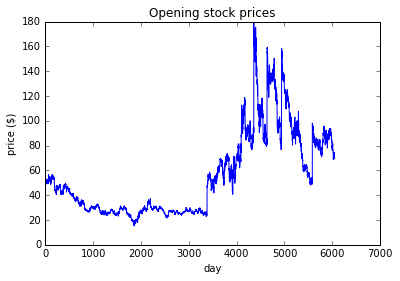

In [28]:
from yahoo_finance import Share
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
%matplotlib inline

class DecisionPolicy:
    def select_action(self, current_state, step):
        pass
    
    def update_q(self, state, action, reward, next_state):
        pass
    
class RandomDecisionPolicy(DecisionPolicy):
    def __init__(self, actions):
        self.actions = actions
        
    def select_action(self, current_state, step):
        action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action

def get_prices(share_symbol, start_date, end_date, cache_filename='stock_prices.npy'):
    try:
        stock_prices = np.load(cache_filename)
    except IOError:
        print("ERROR")
        share = Share(share_symbol)
        stock_hist = share.get_historical(start_date, end_date)
        stock_prices = [stock_price['Open'] for stock_price in stock_hist]
        np.save(cache_filename, stock_prices)
    return stock_prices
        
def plot_prices(prices):
    plt.title('Opening stock prices')
    plt.xlabel('day')
    plt.ylabel('price ($)')
    plt.plot(prices)
    plt.savefig('prices.png')

def run_simulation(policy, initial_budget, initial_num_stocks, prices, hist, debug=False):
    budget = initial_budget
    num_stocks = initial_num_stocks
    share_value = 0
    transitions = list()
    for i in range(len(prices) - hist - 1):
        if i % 100 == 0:
            print('progress {:.2f}%'.format(float(100*i) / (len(prices) - hist - 1)))
        current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, num_stocks)))
        current_portfolio = budget + num_stocks * share_value
        action = policy.select_action(current_state, i)
        share_value = float(prices[i + hist + 1])
        if action == 'Buy' and budget >= share_value:
            budget -= share_value
            num_stocks += 1
        elif action == 'Sell' and num_stocks > 0:
            budget += share_value
            num_stocks -= 1
        else:
            action = 'Hold'
        new_portfolio = budget + num_stocks * share_value
        reward = new_portfolio - current_portfolio
        next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget, num_stocks)))
        transitions.append((current_state, action, reward, next_state))
        policy.update_q(current_state, action, reward, next_state)
        
    portfolio = budget + num_stocks * share_value
    if debug:
        print('${}\t{} shares'.format(budget, num_stocks))
    return portfolio

def run_simulations(policy, budget, num_stocks, prices, hist):
    num_tries = 10
    final_portfolios = list()
    for i in range(num_tries):
        final_portfolio = run_simulation(policy, budget, num_stocks, prices, hist)
        final_portfolios.append(final_portfolio)
    avg, std = np.mean(final_portfolios), np.std(final_portfolios)
    return avg, std

prices = get_prices('MSFT', '1992-07-22', '2016-07-22')
plot_prices(prices)
actions = ['Buy', 'Sell', 'Hold']
hist = 200
policy = RandomDecisionPolicy(actions)
budget = 1000.0
num_stocks = 0
avg, std = run_simulations(policy, budget, num_stocks, prices, hist)
print(avg, std)

In [29]:
class QLearningDecisionPolicy(DecisionPolicy):
    def __init__(self, actions, input_dim):
        self.epsilon = 0.9
        self.gamma = 0.01
        self.actions = actions
        output_dim = len(actions)
        h1_dim = 200
        
        self.x = tf.placeholder(tf.float32, [None, input_dim])
        self.y = tf.placeholder(tf.float32, [output_dim])
        W1 = tf.Variable(tf.random_normal([input_dim, h1_dim]))
        b1 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)
        W2 = tf.Variable(tf.random_normal([h1_dim, output_dim]))
        b2 = tf.Variable(tf.constant(0.1, shape=[output_dim]))
        self.q = tf.nn.relu(tf.matmul(h1,W2)+ b2)
        
        loss = tf.square(self.y - self.q)
        self.train_op = tf.train.AdagradOptimizer(0.01).minimize(loss)
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def select_action(self, current_state, step):
        threshold = min(self.epsilon, step / 1000.)
        if random.random() < threshold:
            action_q_vals = self.sess.run(self.q, feed_dict={self.x: current_state})
            action_idx = np.argmax(action_q_vals)
            action = self.actions[action_idx]
        else:
            action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action
    
    def update_q(self, state, action, reward, next_state):
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})
        next_action_q_vals = self.sess.run(self.q, feed_dict={self.x: next_state})
        next_action_idx = np.argmax(next_action_q_vals)
        action_q_vals[0, next_action_idx] = reward + self.gamma * next_action_q_vals[0, next_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        self.sess.run(self.train_op, feed_dict={self.x: state, self.y: action_q_vals})
        
        

progress 0.00%
progress 1.71%
progress 3.42%
progress 5.13%
progress 6.84%
progress 8.55%
progress 10.26%
progress 11.97%
progress 13.68%
progress 15.40%
progress 17.11%
progress 18.82%
progress 20.53%
progress 22.24%
progress 23.95%
progress 25.66%
progress 27.37%
progress 29.08%
progress 30.79%
progress 32.50%
progress 34.21%
progress 35.92%
progress 37.63%
progress 39.34%
progress 41.05%
progress 42.76%
progress 44.47%
progress 46.19%
progress 47.90%
progress 49.61%
progress 51.32%
progress 53.03%
progress 54.74%
progress 56.45%
progress 58.16%
progress 59.87%
progress 61.58%
progress 63.29%
progress 65.00%
progress 66.71%
progress 68.42%
progress 70.13%
progress 71.84%
progress 73.55%
progress 75.27%
progress 76.98%
progress 78.69%
progress 80.40%
progress 82.11%
progress 83.82%
progress 85.53%
progress 87.24%
progress 88.95%
progress 90.66%
progress 92.37%
progress 94.08%
progress 95.79%
progress 97.50%
progress 99.21%
progress 0.00%
progress 1.71%
progress 3.42%
progress 5.13%
pr

KeyboardInterrupt: 

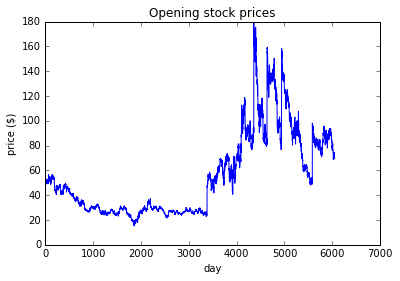

In [30]:
prices = get_prices('MSFT', '1992-07-22', '2016-07-22')
plot_prices(prices)
actions = ['Buy', 'Sell', 'Hold']
hist = 200
policy = QLearningDecisionPolicy(actions, hist + 2)
budget = 1000.0
num_stocks = 0
avg, std = run_simulations(policy, budget, num_stocks, prices, hist)
print(avg, std)

[[    0.          2697.99511719     0.        ]]
[[    0.          2596.19384766     0.        ]]
1
[[  0.          25.96193886   0.        ]]
[  0.          25.96193886   0.        ]
(1000.0, 0.0)


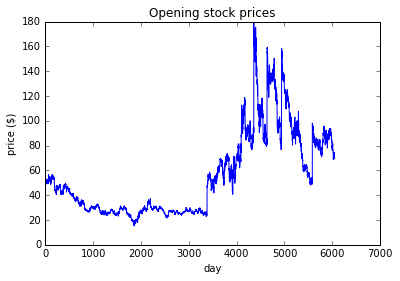

In [36]:
from yahoo_finance import Share
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
%matplotlib inline

class DecisionPolicy:
    def select_action(self, current_state, step):
        pass
    
    def update_q(self, state, action, reward, next_state):
        pass

class QLearningDecisionPolicy(DecisionPolicy):
    def __init__(self, actions, input_dim):
        self.epsilon = 0.9
        self.gamma = 0.01
        self.actions = actions
        output_dim = len(actions)
        h1_dim = 200
        
        self.x = tf.placeholder(tf.float32, [None, input_dim])
        self.y = tf.placeholder(tf.float32, [output_dim])
        W1 = tf.Variable(tf.random_normal([input_dim, h1_dim]))
        b1 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)
        W2 = tf.Variable(tf.random_normal([h1_dim, output_dim]))
        b2 = tf.Variable(tf.constant(0.1, shape=[output_dim]))
        self.q = tf.nn.relu(tf.matmul(h1,W2)+ b2)
        
        loss = tf.square(self.y - self.q)
        self.train_op = tf.train.AdagradOptimizer(0.01).minimize(loss)
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def select_action(self, current_state, step):
        threshold = min(self.epsilon, step / 1000.)
        if random.random() < threshold:
            action_q_vals = self.sess.run(self.q, feed_dict={self.x: current_state})
            action_idx = np.argmax(action_q_vals)
            action = self.actions[action_idx]
        else:
            action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action
    
    def update_q(self, state, action, reward, next_state):
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})
        print(action_q_vals)
        next_action_q_vals = self.sess.run(self.q, feed_dict={self.x: next_state})
        print(next_action_q_vals)
        next_action_idx = np.argmax(next_action_q_vals)
        print(next_action_idx)
        action_q_vals[0, next_action_idx] = reward + self.gamma * next_action_q_vals[0, next_action_idx]
        print(action_q_vals)
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        print(action_q_vals)
        self.sess.run(self.train_op, feed_dict={self.x: state, self.y: action_q_vals})      
    
def get_prices(share_symbol, start_date, end_date, cache_filename='stock_prices.npy'):
    try:
        stock_prices = np.load(cache_filename)
    except IOError:
        print("ERROR")
        share = Share(share_symbol)
        stock_hist = share.get_historical(start_date, end_date)
        stock_prices = [stock_price['Open'] for stock_price in stock_hist]
        np.save(cache_filename, stock_prices)
    return stock_prices
        
def plot_prices(prices):
    plt.title('Opening stock prices')
    plt.xlabel('day')
    plt.ylabel('price ($)')
    plt.plot(prices)
    plt.savefig('prices.png')

def run_simulation(policy, initial_budget, initial_num_stocks, prices, hist, debug=False):
    budget = initial_budget
    num_stocks = initial_num_stocks
    share_value = 0
    transitions = list()
 #   for i in range(len(prices) - hist - 1):
    for i in range(1,2):
        if i % 100 == 0:
            print('progress {:.2f}%'.format(float(100*i) / (len(prices) - hist - 1)))
        current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, num_stocks)))
        current_portfolio = budget + num_stocks * share_value
        action = policy.select_action(current_state, i)
        share_value = float(prices[i + hist + 1])
        if action == 'Buy' and budget >= share_value:
            budget -= share_value
            num_stocks += 1
        elif action == 'Sell' and num_stocks > 0:
            budget += share_value
            num_stocks -= 1
        else:
            action = 'Hold'
        new_portfolio = budget + num_stocks * share_value
        reward = new_portfolio - current_portfolio
        next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget, num_stocks)))
        transitions.append((current_state, action, reward, next_state))
        policy.update_q(current_state, action, reward, next_state)
        
    portfolio = budget + num_stocks * share_value
    if debug:
        print('${}\t{} shares'.format(budget, num_stocks))
    return portfolio

def run_simulations(policy, budget, num_stocks, prices, hist):
    num_tries = 1
    final_portfolios = list()
    for i in range(num_tries):
        final_portfolio = run_simulation(policy, budget, num_stocks, prices, hist)
        final_portfolios.append(final_portfolio)
    avg, std = np.mean(final_portfolios), np.std(final_portfolios)
    return avg, std

prices = get_prices('MSFT', '1992-07-22', '2016-07-22')
plot_prices(prices)
actions = ['Buy', 'Sell', 'Hold']
hist = 200
policy = QLearningDecisionPolicy(actions, hist + 2)
budget = 1000.0
num_stocks = 0
avg, std = run_simulations(policy, budget, num_stocks, prices, hist)
print(avg, std)